<a href="https://colab.research.google.com/github/adhamhelmy/llm-fine-tuning/blob/main/unsloth/Llama3.1_(8B)-GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Installation


In [ ]:
%%capture
import os
os.environ["UNSLOTH_VLLM_STANDBY"] = "1" # [NEW] Extra 30% context lengths! DISABLED due to OOM issues
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install or uv pip install
    !pip install unsloth vllm
else:
    pass # For Colab / Kaggle, we need extra instructions hidden below \/

In [2]:
#@title Colab Extra Install { display-mode: "form" }
import os
!pip install --upgrade -qqq uv
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install!
    !pip install unsloth vllm
else:
    try: import numpy, PIL; get_numpy = f"numpy=={numpy.__version__}"; get_pil = f"pillow=={PIL.__version__}"
    except: get_numpy = "numpy"; get_pil = "pillow"
    try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except: is_t4 = False
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")
    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers
    !uv pip install -qqq {get_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 126.8 MB/s eta 0:00:0000:0100:01
Using Python 3.12.12 environment at: /usr
Resolved 18 packages in 22ms                                         
Prepared 1 package in 437ms                                              
Uninstalled 1 package in 315ms
Installed 1 package in 47ms                                 
 - transformers==4.57.3
 + transformers==4.56.2
Using Python 3.12.12 environment at: /usr
Resolved 1 package in 1ms                                            
Prepared 1 package in 27ms                                               
Uninstalled 1 package in 1ms
Installed 1 package in 6ms                                  
 - trl==0.24.0
 + trl==0.22.2


### Unsloth


Load up `Llama 3.1 8B Instruct`, and set parameters


max_seq_length: This defines the maximum number of tokens (words or sub-word units) that the model will process in a single sequence. Longer sequences require more memory and computation, so reducing this can speed up training but might truncate longer inputs.

lora_rank (or r in get_peft_model): In LoRA (Low-Rank Adaptation) fine-tuning, lora_rank determines the dimensionality of the low-rank matrices added to the model. A higher rank allows for more expressiveness and better adaptation but also increases the number of trainable parameters and VRAM usage. A lower rank means fewer trainable parameters, faster training, and less VRAM, but potentially less model capacity.


In [ ]:
import os
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"

from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = False, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduced to account for vLLM overhead (was 0.9)
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.12/dist-packages/torchao/quantization/quant_api.py:2525: SyntaxWarning: invalid escape sequence '\.'
  * regex for parameter names, must start with `re:`, e.g. `re:language\.layers\..+\.q_proj.weight`.


INFO 12-23 23:27:36 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 12-23 23:27:59 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 12-23 23:27:59 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Llama patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 69.6%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 12-23 23:28:27 [__init__.py:1815] Using max model len 2048
WARNING 12-23 23:28:27 [_ipex_ops.py:16] Import error msg: No module named 'intel_extension_for_pytorch'
INFO 12-23 23:28:30 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 12-23 23:28:30 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.1.mlp'], 'llm_int8_threshold': 6.0}


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO 12-23 23:28:36 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=bitsandbytes, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4

model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

INFO 12-23 23:28:52 [weight_utils.py:369] Time spent downloading weights for unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit: 12.170413 seconds
INFO 12-23 23:28:52 [weight_utils.py:406] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-23 23:28:54 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 12-23 23:28:55 [gpu_model_runner.py:2392] Model loading took 5.6880 GiB and 16.383775 seconds
INFO 12-23 23:29:07 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/a47a65799b/rank_0_0/backbone for vLLM's torch.compile
INFO 12-23 23:29:07 [backends.py:550] Dynamo bytecode transform time: 11.22 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 17.32it/s, triton_poi_fused_view_6]                                 

INFO 12-23 23:29:13 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 26.03it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4] 


INFO 12-23 23:29:52 [backends.py:215] Compiling a graph for dynamic shape takes 42.69 s
INFO 12-23 23:30:06 [monitor.py:34] torch.compile takes 53.91 s in total
INFO 12-23 23:30:08 [gpu_worker.py:298] Available KV cache memory: 48.33 GiB
INFO 12-23 23:30:09 [kv_cache_utils.py:864] GPU KV cache size: 395,936 tokens
INFO 12-23 23:30:09 [kv_cache_utils.py:868] Maximum concurrency for 2,048 tokens per request: 193.33x
INFO 12-23 23:30:09 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:19<00:00,  1.83it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]

INFO 12-23 23:30:34 [gpu_model_runner.py:3118] Graph capturing finished in 25 secs, took 1.19 GiB
INFO 12-23 23:30:34 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 25 secs.


INFO 12-23 23:30:36 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.6960016128672332, 55.21 GiB). Actual usage is 5.69 GiB for weight, 1.16 GiB for peak activation, 0.02 GiB for non-torch memory, and 1.19 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=50463509299` to fit into requested memory, or `--kv-cache-memory=75788048384` to fully utilize gpu memory. Current kv cache memory in use is 51897961267 bytes.
INFO 12-23 23:30:36 [core.py:218] init engine (profile, create kv cache, warmup model) took 100.42 seconds
INFO 12-23 23:30:38 [llm.py:295] Supported_tasks: ('generate',)
INFO 12-23 23:30:38 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'norm1', 'input_layernorm', 'q_norm', 'norm2', 'attention_norm', 'post_attention_layernorm', 'layer_norm2', 'post_feedforward_layernorm', 'norm', 'k_norm', 'pre_

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.12.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Data Prep

<a name="Data"></a>

We directly leverage [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) for data prep and all reward functions. You are free to create your own!


In [4]:
%pip install alpaca-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 11.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from datasets import Dataset
from google.colab import userdata

In [6]:
# Load API Key ID and Secret Key from Colab secrets
API_KEY_ID = "PKYFWRKKNCNJMVFLZD4OYLREDU"
API_SECRET_KEY = "Yh5L9VeVsWPuShX6aUfuZGshyJ8o2RdresyrB9pe5hx"

In [7]:
def load_dataset(symbol: str, start: str, end: str, timeframe: str = "Day"):
    """
    Fetch OHLCV market data from Alpaca.

    Args:
        symbol (str): Ticker symbol, e.g., "AAPL".
        start (str): Start date in ISO format: "2024-01-01".
        end (str): End date in ISO format: "2024-02-01".
        timeframe (str): One of "1Min", "5Min", "15Min", "1Hour", "1Day".

    Returns:
        pandas.DataFrame: DataFrame of bars with Open, High, Low, Close, Volume.
    """

    # Map string to alpaca TimeFrame
    tf_map = {
        "Min": TimeFrame.Minute,
        "Hour": TimeFrame.Hour,
        "Day": TimeFrame.Day,
    }

    client = StockHistoricalDataClient(api_key=API_KEY_ID, secret_key=API_SECRET_KEY)

    request = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=tf_map[timeframe],
        start=datetime.fromisoformat(start),
        end=datetime.fromisoformat(end),
    )

    bars = client.get_stock_bars(request)

    return bars.df

def df_rows_to_text(df, index: int, num_rows: int):
    """
    Extracts `num_rows` rows from `df` starting at `start_index`
    and returns them as a clean text table.

    Args:
        df (pd.DataFrame): Input DataFrame.
        start_index (int): Start index.
        num_rows (int): Number of rows to extract.

    Returns:
        str: Text-formatted table.
    """
    # Slice rows safely
    start_index = index - num_rows if index > num_rows else 0
    subset = df.iloc[start_index : index + 1]

    # Convert to text
    text = subset.to_string()

    return text

def get_close_value(df, index: int):
    """
    Returns the Close value at position `index` in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing a 'Close' column.
        index (int): Row index (0-based).

    Returns:
        float or any: The close value, or None if out of range.
    """

    # Check if index is valid
    if index < 0 or index >= len(df):
        return None

    # Extract Close column value
    return df.iloc[index]["close"]

def format_trading_prompt(market_data: str) -> str:
    """
    Format market data into a prompt for the LLM

    Args:
        market_data: Dict containing price, indicators, portfolio state

    Returns:
        Formatted prompt string

    """

    return f"""

    This is the market data of the last 20 days of AAPL.
      {market_data}

    <balance>{1000000}</balance>
    <position>{1000}</position>

    What action should you take?
    BUY, SELL, or HOLD
    """
    
# Load and prep dataset
SYSTEM_PROMPT = """
You are an expert trading AI. Analyze market conditions and make trading decisions.
Respond with ONLY one of these actions: BUY, SELL, or HOLD

Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""    

def format_questions(df: pd.DataFrame):
    dataset = Dataset.from_pandas(df)   # <-- convert
    data = dataset.map(
        lambda x, idx: {  # <-- receive index
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {
                    "role": "user",
                    "content": format_trading_prompt(df_rows_to_text(df, index=idx, num_rows=20))
                }
            ],
            "answer": f""" {get_close_value(df, idx)}-{get_close_value(df, idx + 1)} """
        },
        with_indices=True,
        remove_columns=dataset.column_names,
    )
    return data

In [ ]:
data = load_dataset("AAPL", "2020-01-01", "2024-01-01") # increased dataset >1000 rows
train_dataset = format_questions(data)

sample_idx = np.random.randint(0, len(train_dataset))
sample_prompt = train_dataset[sample_idx]['prompt']

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

In [9]:
print(f"Sample prompt:\n{sample_prompt}")

Sample prompt:
[{'content': '\nYou are an expert trading AI. Analyze market conditions and make trading decisions.\nRespond with ONLY one of these actions: BUY, SELL, or HOLD\n\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n', 'role': 'system'}, {'content': '\n\n    This is the market data of the last 20 days of AAPL.\n                                           open      high       low   close       volume  trade_count        vwap\nsymbol timestamp                                                                                           \nAAPL   2023-05-16 04:00:00+00:00  171.990  173.1383  171.7991  172.07   45676613.0     436167.0  172.271733\n       2023-05-17 04:00:00+00:00  171.710  172.9250  170.4201  172.69   65903562.0     554943.0  171.956478\n       2023-05-18 04:00:00+00:00  173.000  175.2400  172.5800  175.05   66091664.0     595693.0  174.334502\n       2023-05-19 04:00:00+00:00  176.390  176.3900  174.9400  175.16   58044146.0

### Reward functions


In [10]:
import re

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_balance(text: str):
    balance = text.split("<balance>")[-1]
    balance = balance.split("</balance>")[0]
    return  int(balance)

def extract_position(text: str):
    position = text.split("<position>")[-1]
    position = position.split("</position>")[0]
    return  int(position)


# Reward functions
VALID_ACTIONS = {"BUY", "SELL", "HOLD"}

def take_action(balance, position, action, answer):
  try:
    if action not in VALID_ACTIONS:
      return 0

    [price, new_price] = answer.split('-')

    price = float(price)
    new_price = float(new_price)

    value = balance + position*price

    shares = 10

    if action == 'BUY':
      balance -= shares*price
      position += shares
    elif action == 'SELL':
      balance += shares*price
      position -= shares

    new_value = balance + position*new_price
    
    print(f"Action: {action}, Price: {price}, New Price: {new_price}, Balance: {balance}, Position: {position}, Value: {value}, New Value: {new_value}, Reward: {(new_value - value)/value}")

    return (new_value - value)/value # as % to prevent excessivly large rewards
  except:
    return 0


# calculate trading reward if answer is viable
def trading_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    """
    Calculate reward for a trading action

    This is the key component that guides learning. The reward function
    determines what the model learns to optimize.

    Returns:
        Reward value (higher is better)
    """
    
    b = extract_balance(prompts[0][-1]['content'])
    p = extract_position(prompts[0][-1]['content'])
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20,  f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    result = [take_action(b, p, r, answer[0]) for r in extracted_responses]
    print('-'*20,  f"Result:\n{result}")
    return result

def action_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [3 if r in ["BUY", "SELL", "HOLD"] else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format and answer is BUY, SELL or HOLD."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n(?:BUY|SELL|HOLD)\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [2 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [1 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.2
    if text.count("\n</reasoning>\n") == 1:
        count += 0.2
    if text.count("\n<answer>\n") == 1:
        count += 0.2
    if text.count("\n</answer>") == 1:
        count += 0.2
    if text.count("BUY") == 1 or text.count("SELL") == 1 or text.count("HOLD") == 1:
        count += 0.2
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

### Backtest environment

In [11]:
%pip install backtrader
%pip install alpaca_trade_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 16.7 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp312-cp312-linux_x86_64.whl size=15771 sha256=9d870966c0992f79cea638b6046f586c9e1f3843fc3fda0ca3a7277cc3175f44
  Stored in directory: /root/.cache/pip/wheels/ba/bd/3f/f043e8f634db9c90ae128d631f43ae9990eef01274a63291f9
  Created wheel for websockets: filename=websockets-10.4-cp312-cp312-linux_x86_64.whl size=107403 sha256=3153eb22475b4dca88ba1d2dc75ef6d0ebdee456d53af35509aeeac1dc

In [12]:
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.stream import Stream

rest_api = REST(API_KEY_ID, API_SECRET_KEY, 'https://paper-api.alpaca.markets')

In [13]:
import backtrader as bt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140 # chart resolution

def run_backtest(strategy, symbols, start, end, timeframe=TimeFrame.Day, cash=10000):
    '''params:
        strategy: the strategy you wish to backtest, an instance of backtrader.Strategy
        symbols: the symbol (str) or list of symbols List[str] you wish to backtest on
        start: start date of backtest in format 'YYYY-MM-DD'
        end: end date of backtest in format: 'YYYY-MM-DD'
        timeframe: the timeframe the strategy trades on (size of bars) -
                   1 min: TimeFrame.Minute, 1 day: TimeFrame.Day, 5 min: TimeFrame(5, TimeFrameUnit.Minute)
        cash: the starting cash of backtest
    '''

    # initialize backtrader broker
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.setcash(cash)

    # add strategy
    cerebro.addstrategy(strategy)

    # add analytics
    # cerebro.addobserver(bt.observers.Value)
    # cerebro.addobserver(bt.observers.BuySell)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')

    # historical data request
    if type(symbols) == str:
        symbol = symbols
        alpaca_data = rest_api.get_bars(symbol, timeframe, start, end,  adjustment='all').df
        data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
        cerebro.adddata(data)
    elif type(symbols) == list or type(symbols) == set:
        for symbol in symbols:
            alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
            data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
            cerebro.adddata(data)

    # run
    initial_portfolio_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {initial_portfolio_value}')
    results = cerebro.run()
    final_portfolio_value = cerebro.broker.getvalue()
    print(f'Final Portfolio Value: {final_portfolio_value} ---> Return: {(final_portfolio_value/initial_portfolio_value - 1)*100}%')

    strat = results[0]
    print('Sharpe Ratio:', strat.analyzers.mysharpe.get_analysis()['sharperatio'])
    # plot (non-interactive backend) -> save figures and display in notebook
    import matplotlib.pyplot as plt
    from IPython.display import Image, display

    cerebro.plot(iplot=False)  # creates matplotlib figures when using Agg
    for i, fig_num in enumerate(plt.get_fignums(), start=1):
        plt.figure(fig_num)
        filename = f'backtest_plot_{i}.png'
        plt.savefig(filename, dpi=140, bbox_inches='tight')
        display(Image(filename))
    plt.close('all')

In [ ]:
from vllm import SamplingParams

class LLMTradingStrategy(bt.Strategy):
    def __init__(self):
        self.window_size = 20
        self.price_history = []
        self.valid_actions = 0
        self.invalid_actions = 0
    
    def next(self):
        # Collect price data
        self.price_history.append(self.data.close[0])
        if len(self.price_history) > self.window_size:
            self.price_history.pop(0)
        
        # Generate signal only when we have enough data
        if len(self.price_history) >= self.window_size:
            market_data = "\n".join([f"Day {i}: {price:.2f}" 
                                     for i, price in enumerate(self.price_history)])
            
            # Format prompt for model
            prompt_text = f"""
            This is the market data of the last {self.window_size} days.
            {market_data}
            
            <balance>1000000</balance>
            <position>1000</position>
            
            What action should you take?
            BUY, SELL, or HOLD
            """
            
            # Get model prediction
            text = tokenizer.apply_chat_template([
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt_text}
            ], tokenize=False, add_generation_prompt=True)
            
            output = model.fast_generate(
                [text],
                sampling_params=SamplingParams(temperature=0.7, top_p=0.95, max_tokens=256),
                lora_request=lora_request
            )[0].outputs[0].text
            
            
            action = extract_xml_answer(output).strip().upper()
            
            if action in VALID_ACTIONS:
                print(f"Date: {self.data.datetime.date(0)} Action: {action}")
            
            # print(f"Position: {self.position.size} Cash: {self.broker.get_cash()} Total Value: {self.broker.get_value()}")
            
            # Execute trades
            if action == "BUY":
                self.buy(size=10)
                self.valid_actions += 1
            elif action == "SELL" and self.position:
                self.sell(size=10)
                self.valid_actions += 1
            elif action == "HOLD":
                self.valid_actions += 1    
            else:
                self.invalid_actions += 1  
                print("Invalid action")
                
            # print(f"Position: {self.position.size} Cash: {self.broker.get_cash()} Total Value: {self.broker.get_value()}")
            print(f"Valid actions: {self.valid_actions}, Invalid actions: {self.invalid_actions}")      
# run_backtest(LLMTradingStrategy, 'AAPL', '2019-01-01', '2021-11-01', TimeFrame.Day, 1000000)

<a name="Train"></a>

### Train the model

Now set up GRPO Trainer and all configurations!


num_generations: In the context of the GRPO (Generative Reinforcement Learning with Policy Optimization) trainer, this parameter specifies how many completions (or responses) the model generates for each prompt during the training loop. More generations can lead to more diverse feedback and potentially better policy learning, but directly increases the computation required per training step.

max_steps: This sets the total number of optimization steps the trainer will perform during the entire training run. Training will stop once this limit is reached, regardless of other criteria like epochs. Reducing max_steps will shorten the total training time.

save_steps: This determines how often (in terms of training steps) the model's checkpoints are saved. For example, if save_steps is 100, the model will be saved every 100 steps. This is useful for retaining intermediate models in case training is interrupted or if you want to evaluate models at different stages.


In [ ]:
max_prompt_length = 512

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 8, # Increase to 4 for smoother training
    num_generations = 3, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    num_train_epochs = 3, # Set to 1 for a full training run
    max_steps = 100,
    save_steps = 100,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` * `gradient_accumulation_steps` * `world_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 3


And let's run the trainer! If you scroll up, you'll see a table of rewards. The goal is to see the `reward` column increase!

You might have to wait 150 to 200 steps for any action. You'll probably get 0 reward for the first 100 steps. Please be patient!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
| ---- | ------------- | --------- | ---------- | ----------------- | -------- |
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |


In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        action_reward_func,
        trading_reward_func,
    ],
    args = training_args,
    train_dataset = train_dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 501 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 3 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (3 x 1 x 1) = 3
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!
-------------------- 
Answer:
 151.76-149.84  
Response:
</reasoning>
After analyzing the 20-day market data, I notice a downtrend in the price of AAPL, with a 10-day period of rejection at around 157-158 levels. However, the last two candles show a bullish reversal with AAPL regaining traction, but only slightly. With a growing volume, it indicates buying interest is re-emerging.

</reasoning>
BUY 
Extracted:
</reasoning>
After analyzing the 20-day market data, I notice a downtrend in the price of AAPL, with a 10-day period of rejection at around 157-158 levels. However, the last two candles show a bullish reversal with AAPL regaining traction, but only slightly. With a growing volume, it indicates buying interest is re-emerging.

</reasoning>
BUY
Action: BUY, Price: 151.76, New Price: 149.84, Balance: 998482.4, Position: 1010, Value: 1151760.0, New Value: 1149820.8, Reward: -0.0016836841008543043
-------------------- Result:
[0, 0

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / action_reward_func / mean,rewards / action_reward_func / std,rewards / trading_reward_func / mean,rewards / trading_reward_func / std
1,0.000000,0.999439,1.731079,128.333344,82.000000,182.000000,0.000000,128.333344,82.000000,182.000000,0.000000,1.000000,1.732051,-0.000561,0.000972
2,0.000000,1.000782,1.733406,135.000000,124.000000,153.000000,0.000000,135.000000,124.000000,153.000000,0.000000,1.000000,1.732051,0.000782,0.001355
3,0.000000,0.000000,0.000000,288.000000,77.000000,644.000000,0.333333,110.000000,77.000000,143.000000,0.000684,0.000000,0.000000,0.000000,0.000000
4,0.000000,2.000729,1.732682,171.666672,112.000000,233.000000,0.000000,171.666672,112.000000,233.000000,0.000832,2.000000,1.732051,0.000728,0.000631
5,0.000000,1.000547,1.732998,141.000000,76.000000,188.000000,0.000000,141.000000,76.000000,188.000000,0.000894,1.000000,1.732051,0.000547,0.000947
6,0.000000,0.999503,1.731191,165.000000,116.000000,243.000000,0.000000,165.000000,116.000000,243.000000,0.000643,1.000000,1.732051,-0.000497,0.000860
7,0.000000,1.998853,1.731057,189.000000,156.000000,252.000000,0.000000,189.000000,156.000000,252.000000,0.000675,2.000000,1.732051,-0.001147,0.000994
8,0.000000,1.997354,1.729759,205.333344,146.000000,309.000000,0.000000,205.333344,146.000000,309.000000,0.000699,2.000000,1.732051,-0.002646,0.002292
9,0.000000,0.999693,1.731519,180.333344,98.000000,248.000000,0.000000,180.333344,98.000000,248.000000,0.000860,1.000000,1.732051,-0.000307,0.000532
10,0.001400,2.998910,0.000013,146.333344,141.000000,155.000000,0.000000,146.333344,141.000000,155.000000,0.000866,3.000000,0.000000,-0.001091,0.000013


-------------------- 
Answer:
 167.66-170.4  
Response:
<Analyzing the recent trend of AAPL stock, the price has been steadily increasing over the past 20 days, showing no significant sign of reversal. The volatility has also been relatively low compared to historical data. However, there is a slight decline in the trading volume which indicates a possible downward convergence. One should monitor the market for any changes in trading volume and momentum.

Although the current market situation suggests a strong trend of rising stock prices, there's less than certain reason to conclude if it will continue in the near future and strongly hints towards a possible reversal soon.
No trade signal is strong enough to dramatically conclude what option should we opt for in this rising market, but my advice is a for conservative action.

</reasoning>
SELL
</answer> 
Extracted:
<Analyzing the recent trend of AAPL stock, the price has been steadily increasing over the past 20 days, showing no signi

TrainOutput(global_step=100, training_loss=4.356766575920545e-05, metrics={'train_runtime': 721.6092, 'train_samples_per_second': 0.416, 'train_steps_per_second': 0.139, 'total_flos': 0.0, 'train_loss': 4.356766575920545e-05})

<a name="Inference"></a>

### Inference

Now let's try the model we just trained! First, let's first try the model without any GRPO trained:


Starting Portfolio Value: 1000000


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738915.2083333334 Action: BUY
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Valid actions: 1, Invalid actions: 0


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738916.2083333334 Action: BUY
Position: 10 Cash: 998147.0 Total Value: 999973.9
Position: 10 Cash: 998147.0 Total Value: 999973.9
Valid actions: 2, Invalid actions: 0


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738917.2083333334 Action: BUY
Position: 20 Cash: 996324.2 Total Value: 1000026.7999999999
Position: 20 Cash: 996324.2 Total Value: 1000026.7999999999
Valid actions: 3, Invalid actions: 0


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738918.2083333334 Action: BUY
Position: 30 Cash: 994542.2999999999 Total Value: 1000066.2
Position: 30 Cash: 994542.2999999999 Total Value: 1000066.2
Valid actions: 4, Invalid actions: 0


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 40 Cash: 992678.2999999999 Total Value: 1000115.8999999999
Invalid action
Position: 40 Cash: 992678.2999999999 Total Value: 1000115.8999999999
Valid actions: 4, Invalid actions: 1


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 40 Cash: 992678.2999999999 Total Value: 1000179.8999999999
Invalid action
Position: 40 Cash: 992678.2999999999 Total Value: 1000179.8999999999
Valid actions: 4, Invalid actions: 2


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738923.2083333334 Action: BUY
Position: 40 Cash: 992678.2999999999 Total Value: 1000184.2999999999
Position: 40 Cash: 992678.2999999999 Total Value: 1000184.2999999999
Valid actions: 5, Invalid actions: 2


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 50 Cash: 990801.9999999999 Total Value: 1000130.4999999999
Invalid action
Position: 50 Cash: 990801.9999999999 Total Value: 1000130.4999999999
Valid actions: 5, Invalid actions: 3


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 50 Cash: 990801.9999999999 Total Value: 1000168.9999999999
Invalid action
Position: 50 Cash: 990801.9999999999 Total Value: 1000168.9999999999
Valid actions: 5, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738928.2083333334 Action: BUY
Position: 50 Cash: 990801.9999999999 Total Value: 1000084.4999999999
Position: 50 Cash: 990801.9999999999 Total Value: 1000084.4999999999
Valid actions: 6, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988959.1999999998 Total Value: 999972.7999999998
Invalid action
Position: 60 Cash: 988959.1999999998 Total Value: 999972.7999999998
Valid actions: 6, Invalid actions: 5


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738930.2083333334 Action: SELL
Position: 60 Cash: 988959.1999999998 Total Value: 999919.3999999998
Position: 60 Cash: 988959.1999999998 Total Value: 999919.3999999998
Valid actions: 7, Invalid actions: 5


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 50 Cash: 990779.9999999999 Total Value: 999899.4999999999
Invalid action
Position: 50 Cash: 990779.9999999999 Total Value: 999899.4999999999
Valid actions: 7, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738932.2083333334 Action: SELL
Position: 50 Cash: 990779.9999999999 Total Value: 999822.4999999999
Position: 50 Cash: 990779.9999999999 Total Value: 999822.4999999999
Valid actions: 8, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 40 Cash: 992583.2999999999 Total Value: 999787.2999999999
Invalid action
Position: 40 Cash: 992583.2999999999 Total Value: 999787.2999999999
Valid actions: 8, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738937.2083333334 Action: BUY
Position: 40 Cash: 992583.2999999999 Total Value: 999817.7
Position: 40 Cash: 992583.2999999999 Total Value: 999817.7
Valid actions: 9, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738938.2083333334 Action: BUY
Position: 50 Cash: 990763.2 Total Value: 999907.7
Position: 50 Cash: 990763.2 Total Value: 999907.7
Valid actions: 10, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988927.8999999999 Total Value: 999791.4999999999
Invalid action
Position: 60 Cash: 988927.8999999999 Total Value: 999791.4999999999
Valid actions: 10, Invalid actions: 8


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988927.8999999999 Total Value: 999710.4999999999
Invalid action
Position: 60 Cash: 988927.8999999999 Total Value: 999710.4999999999
Valid actions: 10, Invalid actions: 9


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988927.8999999999 Total Value: 999798.0999999999
Invalid action
Position: 60 Cash: 988927.8999999999 Total Value: 999798.0999999999
Valid actions: 10, Invalid actions: 10


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738944.2083333334 Action: HOLD
Position: 60 Cash: 988927.8999999999 Total Value: 999725.4999999999
Position: 60 Cash: 988927.8999999999 Total Value: 999725.4999999999
Valid actions: 11, Invalid actions: 10


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988927.8999999999 Total Value: 999685.8999999999
Invalid action
Position: 60 Cash: 988927.8999999999 Total Value: 999685.8999999999
Valid actions: 11, Invalid actions: 11


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988927.8999999999 Total Value: 999621.0999999999
Invalid action
Position: 60 Cash: 988927.8999999999 Total Value: 999621.0999999999
Valid actions: 11, Invalid actions: 12
Final Portfolio Value: 999621.0999999999 ---> Return: -0.03789000000001819%
Sharpe Ratio: None


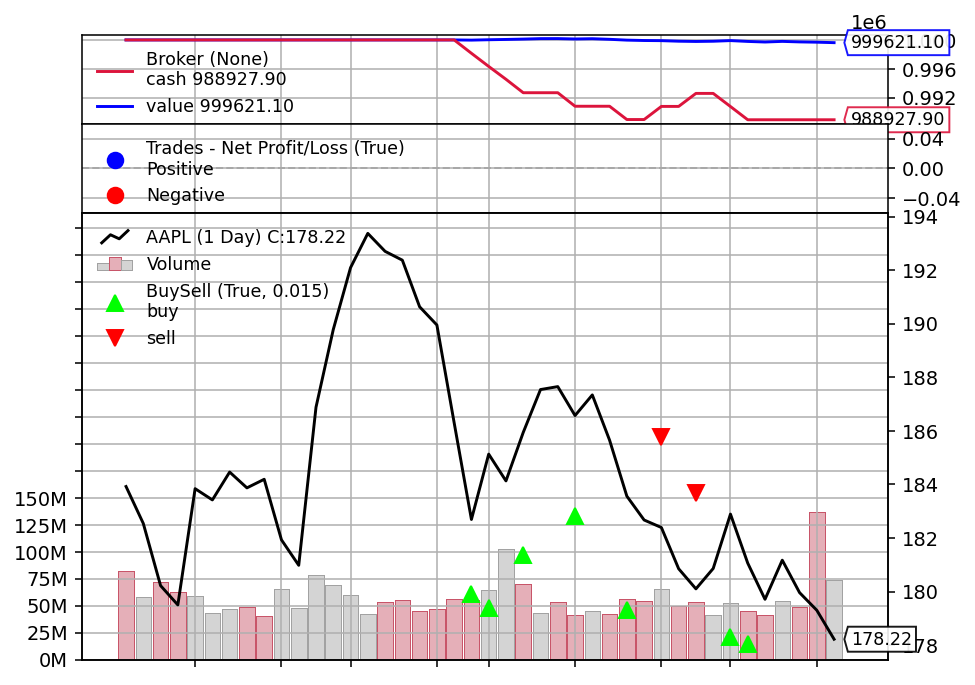

In [45]:
lora_request = None
run_backtest(LLMTradingStrategy, 'AAPL', '2024-01-01', '2024-03-01', TimeFrame.Day, 1000000)

And now with the LoRA we just trained with GRPO - we first save the LoRA first!


In [22]:
model.save_lora("grpo_saved_lora")

Now we load the LoRA and test:


In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : "Calculate pi."},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)

output = model.fast_generate(
    [text],
    sampling_params=sampling_params,
    lora_request=None,
)[0].outputs[0].text


output

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

"I'm not designed to calculate pi, but rather to provide trading advice."

Our reasoning model is much better - it's not always correct, since we only trained it for an hour or so - it'll be better if we extend the sequence length and train for longer!


Starting Portfolio Value: 1000000


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738915.2083333334 Action: SELL
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Invalid action
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Valid actions: 0, Invalid actions: 1


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Invalid action
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Valid actions: 0, Invalid actions: 2


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738917.2083333334 Action: BUY
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Position: 0 Cash: 1000000.0 Total Value: 1000000.0
Valid actions: 1, Invalid actions: 2


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 10 Cash: 998218.1 Total Value: 1000059.4
Invalid action
Position: 10 Cash: 998218.1 Total Value: 1000059.4
Valid actions: 1, Invalid actions: 3


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 10 Cash: 998218.1 Total Value: 1000077.5
Invalid action
Position: 10 Cash: 998218.1 Total Value: 1000077.5
Valid actions: 1, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738922.2083333334 Action: BUY
Position: 10 Cash: 998218.1 Total Value: 1000093.5
Position: 10 Cash: 998218.1 Total Value: 1000093.5
Valid actions: 2, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738923.2083333334 Action: BUY
Position: 20 Cash: 996329.4 Total Value: 1000082.4
Position: 20 Cash: 996329.4 Total Value: 1000082.4
Valid actions: 3, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738924.2083333334 Action: BUY
Position: 30 Cash: 994453.1 Total Value: 1000050.2
Position: 30 Cash: 994453.1 Total Value: 1000050.2
Valid actions: 4, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738925.2083333334 Action: BUY
Position: 40 Cash: 992581.7 Total Value: 1000075.2999999999
Position: 40 Cash: 992581.7 Total Value: 1000075.2999999999
Valid actions: 5, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738928.2083333334 Action: BUY
Position: 50 Cash: 990712.7 Total Value: 999995.2
Position: 50 Cash: 990712.7 Total Value: 999995.2
Valid actions: 6, Invalid actions: 4


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 60 Cash: 988869.8999999999 Total Value: 999883.4999999999
Invalid action
Position: 60 Cash: 988869.8999999999 Total Value: 999883.4999999999
Valid actions: 6, Invalid actions: 5


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738930.2083333334 Action: SELL
Position: 60 Cash: 988869.8999999999 Total Value: 999830.0999999999
Position: 60 Cash: 988869.8999999999 Total Value: 999830.0999999999
Valid actions: 7, Invalid actions: 5


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 50 Cash: 990690.7 Total Value: 999810.2
Invalid action
Position: 50 Cash: 990690.7 Total Value: 999810.2
Valid actions: 7, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738932.2083333334 Action: BUY
Position: 50 Cash: 990690.7 Total Value: 999733.2
Position: 50 Cash: 990690.7 Total Value: 999733.2
Valid actions: 8, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738936.2083333334 Action: SELL
Position: 60 Cash: 988887.3999999999 Total Value: 999693.3999999999
Position: 60 Cash: 988887.3999999999 Total Value: 999693.3999999999
Valid actions: 9, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738937.2083333334 Action: SELL
Position: 50 Cash: 990692.2 Total Value: 999735.2
Position: 50 Cash: 990692.2 Total Value: 999735.2
Valid actions: 10, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738938.2083333334 Action: HOLD
Position: 40 Cash: 992512.2999999999 Total Value: 999827.8999999999
Position: 40 Cash: 992512.2999999999 Total Value: 999827.8999999999
Valid actions: 11, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738939.2083333334 Action: HOLD
Position: 40 Cash: 992512.2999999999 Total Value: 999754.7
Position: 40 Cash: 992512.2999999999 Total Value: 999754.7
Valid actions: 12, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738942.2083333334 Action: SELL
Position: 40 Cash: 992512.2999999999 Total Value: 999700.7
Position: 40 Cash: 992512.2999999999 Total Value: 999700.7
Valid actions: 13, Invalid actions: 6


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Position: 30 Cash: 994308.7999999999 Total Value: 999743.8999999999
Invalid action
Position: 30 Cash: 994308.7999999999 Total Value: 999743.8999999999
Valid actions: 13, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738944.2083333334 Action: BUY
Position: 30 Cash: 994308.7999999999 Total Value: 999707.6
Position: 30 Cash: 994308.7999999999 Total Value: 999707.6
Valid actions: 14, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738945.2083333334 Action: BUY
Position: 40 Cash: 992510.6 Total Value: 999682.6
Position: 40 Cash: 992510.6 Total Value: 999682.6
Valid actions: 15, Invalid actions: 7


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Date: 738946.2083333334 Action: SELL
Position: 50 Cash: 990729.5 Total Value: 999640.5
Position: 50 Cash: 990729.5 Total Value: 999640.5
Valid actions: 16, Invalid actions: 7
Final Portfolio Value: 999640.5 ---> Return: -0.03594999999999571%
Sharpe Ratio: None


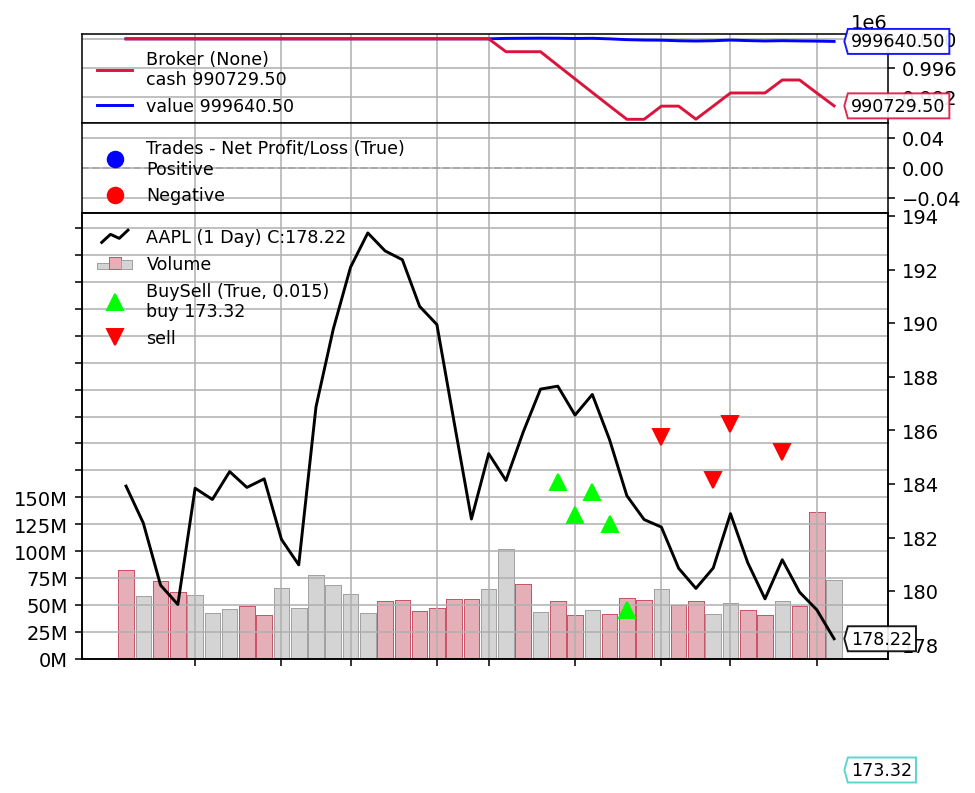

In [46]:
lora_request = model.load_lora("grpo_saved_lora")
run_backtest(LLMTradingStrategy, 'AAPL', '2024-01-01', '2024-03-01', TimeFrame.Day, 1000000)

<a name="Save"></a>

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.


In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")


### GGUF / llama.cpp Conversion

To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):

- `q8_0` - Fast conversion. High resource use, but generally acceptable.
- `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
- `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](<https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb>)


In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:

1. Train your own reasoning model - Llama GRPO notebook [Free Colab](<https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb>)
2. Saving finetunes to Ollama. [Free notebook](<https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb>)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](<https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb>)
4. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️

</div>

This notebook and all Unsloth notebooks are licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme).
